# Stage 3 --- Improving the model with Hyperparameter Tuning --- 
# Use Hyperparameter tuning to find the best parameters for our model 

In [1]:
import pandas as pd

X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv').values.ravel()


In [6]:
print(X_train.shape)  # (number_of_samples, number_of_features)
print(y_train.shape)  # (number_of_samples,)
print(X_test.shape)
print(y_test.shape)

(1030, 12)
(1030,)
(258, 12)
(258,)


In [7]:
from collections import Counter
print(Counter(y_train))


Counter({np.int64(2): 357, np.int64(1): 352, np.int64(0): 321})


# Handle Class Imbalance 
# ------------------------------

In [8]:
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

# No resampling needed
X_resampled = X_train.copy()
y_resampled = y_train.copy()

# Ensure y_resampled is a Pandas Series for .iloc support
y_resampled = pd.Series(y_resampled)

# Compute class weights
classes = np.unique(y_resampled)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)

# Map class weights to sample weights
class_weights_dict = dict(zip(classes, weights))
sample_weights = np.array([class_weights_dict[y] for y in y_resampled])


# Plotintg Function
# ---------------------------

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix_sklearn(y_true, y_pred, class_names, model_name="Model", figsize=(18, 7), cmap=plt.cm.Blues):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(f"Confusion Matrices for {model_name}", fontsize=16)

    # Raw counts
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=class_names,
        cmap=cmap,
        values_format='d',
        ax=axes[0]
    )
    axes[0].set_title('Confusion Matrix (Raw Counts)')

    # Normalized
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=class_names,
        cmap=cmap,
        normalize='true',
        values_format='.2f',
        ax=axes[1]
    )
    axes[1].set_title('Normalized Confusion Matrix (Row-wise)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


#  Define Traditional ML Models and selection using OPTUNA
# --------------------------------------------------------------

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn import ensemble
import optuna

# --- Cross-validation strategy ---
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# --- Store history ---
model_history = []

# --- Objective functions ---
def rf_objective(trial):
    # params = {
    #     "n_estimators": trial.suggest_categorical("n_estimators", [200, 300, 500]),
    #     "max_features": trial.suggest_categorical("max_features", ['sqrt', 'log2', None]),
    #     "max_depth": trial.suggest_categorical("max_depth", [4, 5, 6, 7, 8, 9, 10]),
    #     "criterion": trial.suggest_categorical("criterion", ['gini', 'entropy']),
    #     "random_state": 42
    # }
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [50, 100, 200]),
        "max_depth": trial.suggest_categorical("max_depth", [None, 10, 20]),
        "min_samples_split": trial.suggest_categorical("min_samples_split", [2, 5, 10]),
        "random_state": 42
    }
    
    model = ensemble.RandomForestClassifier(**params)

    scores = []
    for train_idx, val_idx in cv.split(X_resampled, y_resampled):
        X_train_fold = X_resampled.iloc[train_idx]
        y_train_fold = y_resampled.iloc[train_idx]
        X_val_fold = X_resampled.iloc[val_idx]
        y_val_fold = y_resampled.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        score = balanced_accuracy_score(y_val_fold, preds)
        scores.append(score)

    avg_score = np.mean(scores)
    model_history.append({"model": "Random Forest", "trial": trial.number, "score": avg_score, "params": params})
    return avg_score


def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [50, 100, 200]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.1, 0.2]),
        "max_depth": trial.suggest_categorical("max_depth", [3, 5, 10]),
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "random_state": 42,
        # "use_label_encoder": False
    }
    model = XGBClassifier(**params)

    scores = []
    for train_idx, val_idx in cv.split(X_resampled, y_resampled):
        X_train_fold = X_resampled.iloc[train_idx]
        y_train_fold = y_resampled.iloc[train_idx]
        X_val_fold = X_resampled.iloc[val_idx]
        y_val_fold = y_resampled.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        score = balanced_accuracy_score(y_val_fold, preds)
        scores.append(score)

    avg_score = np.mean(scores)
    model_history.append({"model": "XGBoost", "trial": trial.number, "score": avg_score, "params": params})
    return avg_score


def ab_objective(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [50, 100, 200]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.1, 1])
    }
    base_estimator = DecisionTreeClassifier(random_state=42)
    model = AdaBoostClassifier(estimator=base_estimator, random_state=42, **params)

    scores = []
    for train_idx, val_idx in cv.split(X_resampled, y_resampled):
        X_train_fold = X_resampled.iloc[train_idx]
        y_train_fold = y_resampled.iloc[train_idx]
        X_val_fold = X_resampled.iloc[val_idx]
        y_val_fold = y_resampled.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        score = balanced_accuracy_score(y_val_fold, preds)
        scores.append(score)

    avg_score = np.mean(scores)
    model_history.append({"model": "AdaBoost", "trial": trial.number, "score": avg_score, "params": params})
    return avg_score



In [11]:
# --- Run studies ---
def run_study(objective, name, n_trials=100):
    print(f"\nRunning Optuna for {name}...")
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    print(f"[{name}] Best Params: {study.best_params}")
    print(f"[{name}] Best Balanced Accuracy: {study.best_value:.4f}")
    return study

rf_study = run_study(rf_objective, "Random Forest")
xgb_study = run_study(xgb_objective, "XGBoost")
ab_study = run_study(ab_objective, "AdaBoost")



Running Optuna for Random Forest...
[Random Forest] Best Params: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5}
[Random Forest] Best Balanced Accuracy: 0.9539

Running Optuna for XGBoost...
[XGBoost] Best Params: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 5}
[XGBoost] Best Balanced Accuracy: 0.9522

Running Optuna for AdaBoost...
[AdaBoost] Best Params: {'n_estimators': 100, 'learning_rate': 0.01}
[AdaBoost] Best Balanced Accuracy: 0.9222


In [12]:
# --- Convert history to DataFrame ---
model_history_df = pd.DataFrame(model_history)
model_history_df = model_history_df.sort_values(by='score', ascending=False).reset_index(drop=True)
print("\nTop 5 Trials:")
print(model_history_df.head())


Top 5 Trials:
           model  trial     score  \
0  Random Forest     99  0.953884   
1  Random Forest     98  0.953884   
2  Random Forest     97  0.953884   
3  Random Forest     31  0.953884   
4  Random Forest     27  0.953884   

                                              params  
0  {'n_estimators': 200, 'max_depth': 20, 'min_sa...  
1  {'n_estimators': 200, 'max_depth': None, 'min_...  
2  {'n_estimators': 200, 'max_depth': 20, 'min_sa...  
3  {'n_estimators': 200, 'max_depth': 20, 'min_sa...  
4  {'n_estimators': 200, 'max_depth': 20, 'min_sa...  


# Model Performence Throughout The Optimization
# --------------------------------------------------

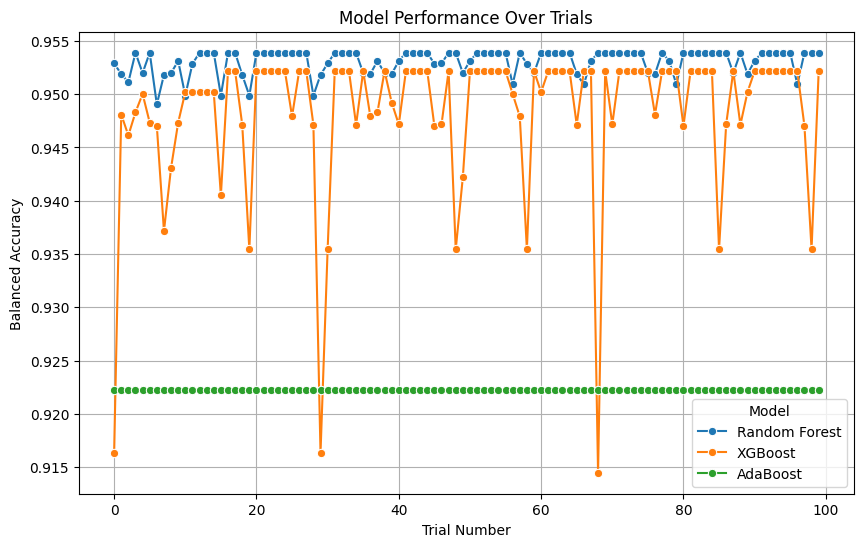

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(data=model_history_df, x="trial", y="score", hue="model", marker="o")
plt.title("Model Performance Over Trials")
plt.ylabel("Balanced Accuracy")
plt.xlabel("Trial Number")
plt.legend(title="Model")
plt.grid(True)
plt.show()


# ---------Model Eavaluation Functions--------------

In [14]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

def evaluate_optuna_model(model_name, best_model, X_test, y_test):
    
    # Predict on the test data
    predictions = best_model.predict(X_test)

    # Evaluate metrics
    accuracy = accuracy_score(y_test, predictions)
    balanced_acc = balanced_accuracy_score(y_test, predictions)

    # Display
    print(f"[{model_name}] Test Accuracy: {accuracy:.4f}")
    print(f"[{model_name}] Balanced Accuracy: {balanced_acc:.4f}")
    print(f"[{model_name}] Classification Report:\n{classification_report(y_test, predictions, zero_division=0)}")

    return predictions


# -------------Eavaluation----------

[Random Forest] Test Accuracy: 0.9341
[Random Forest] Balanced Accuracy: 0.9330
[Random Forest] Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92        80
           1       0.92      0.89      0.90        88
           2       0.95      1.00      0.97        90

    accuracy                           0.93       258
   macro avg       0.93      0.93      0.93       258
weighted avg       0.93      0.93      0.93       258



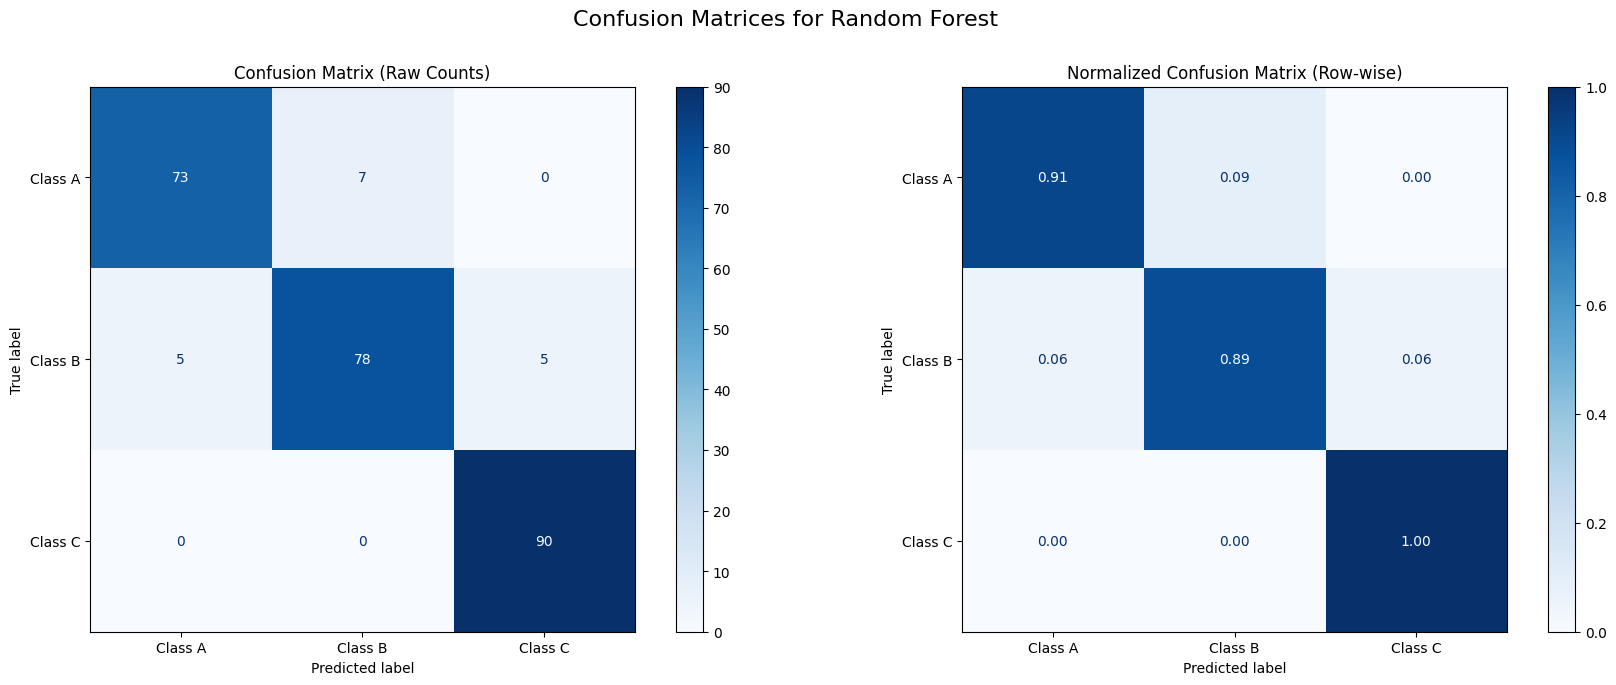

In [15]:
best_rf = RandomForestClassifier(**rf_study.best_params)
best_rf.fit(X_resampled, y_resampled)  # Fit on the final full (resampled) train set

# Evaluate
predictions = evaluate_optuna_model("Random Forest", best_rf, X_test, y_test)
plot_confusion_matrix_sklearn(y_test, predictions, class_names=['Class A', 'Class B', 'Class C'], model_name="Random Forest", figsize=(18, 7), cmap=plt.cm.Blues) # type: ignore

[XGBoost] Test Accuracy: 0.9380
[XGBoost] Balanced Accuracy: 0.9379
[XGBoost] Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        80
           1       0.95      0.86      0.90        88
           2       0.93      1.00      0.96        90

    accuracy                           0.94       258
   macro avg       0.94      0.94      0.94       258
weighted avg       0.94      0.94      0.94       258



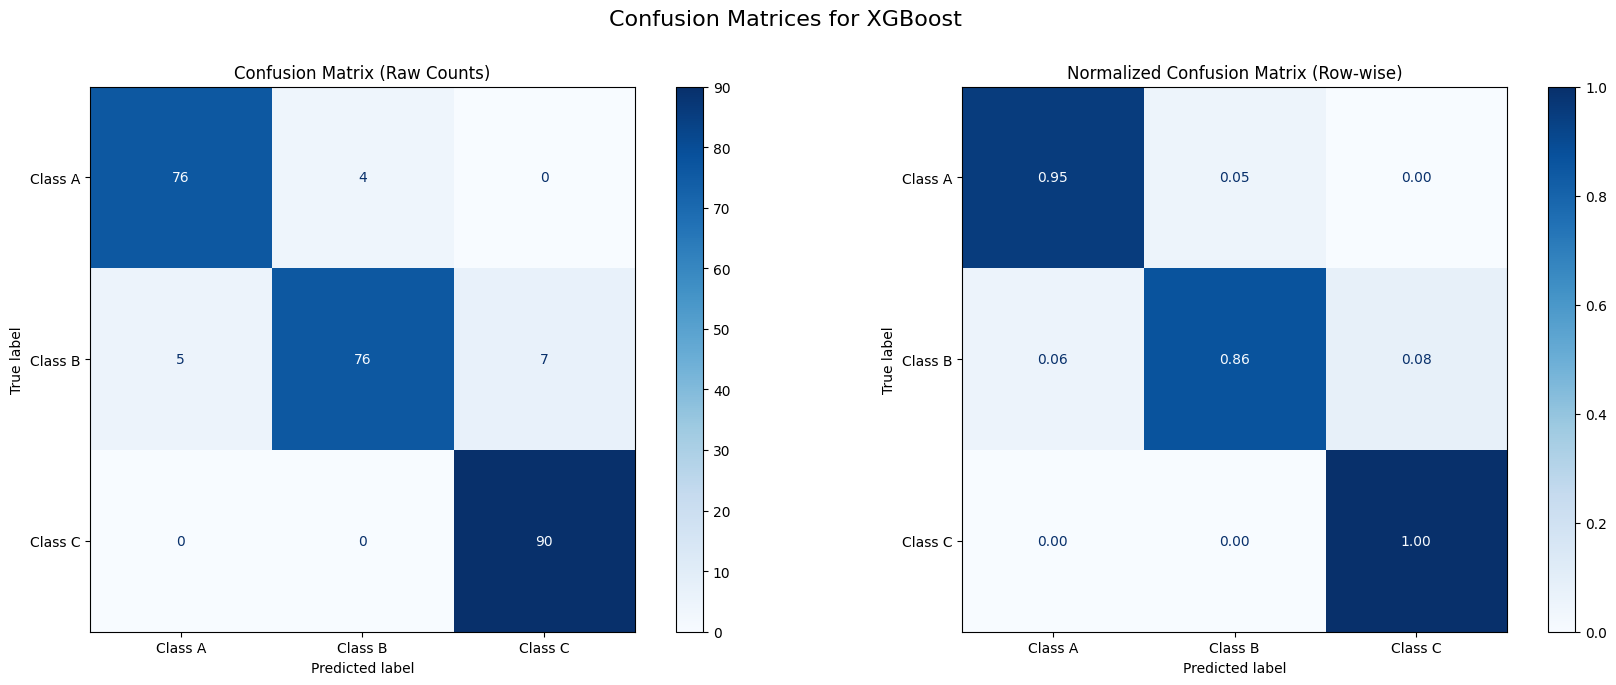

In [16]:
best_xgb = XGBClassifier(**xgb_study.best_params)
best_xgb.fit(X_resampled, y_resampled)  

# Evaluate
predictions = evaluate_optuna_model("XGBoost", best_xgb, X_test, y_test)
plot_confusion_matrix_sklearn(y_test, predictions, class_names=['Class A', 'Class B', 'Class C'], model_name="XGBoost", figsize=(18, 7), cmap=plt.cm.Blues) # type: ignore

[AdaBoost] Test Accuracy: 0.7093
[AdaBoost] Balanced Accuracy: 0.7151
[AdaBoost] Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        80
           1       0.81      0.28      0.42        88
           2       0.61      0.91      0.73        90

    accuracy                           0.71       258
   macro avg       0.75      0.72      0.68       258
weighted avg       0.74      0.71      0.67       258



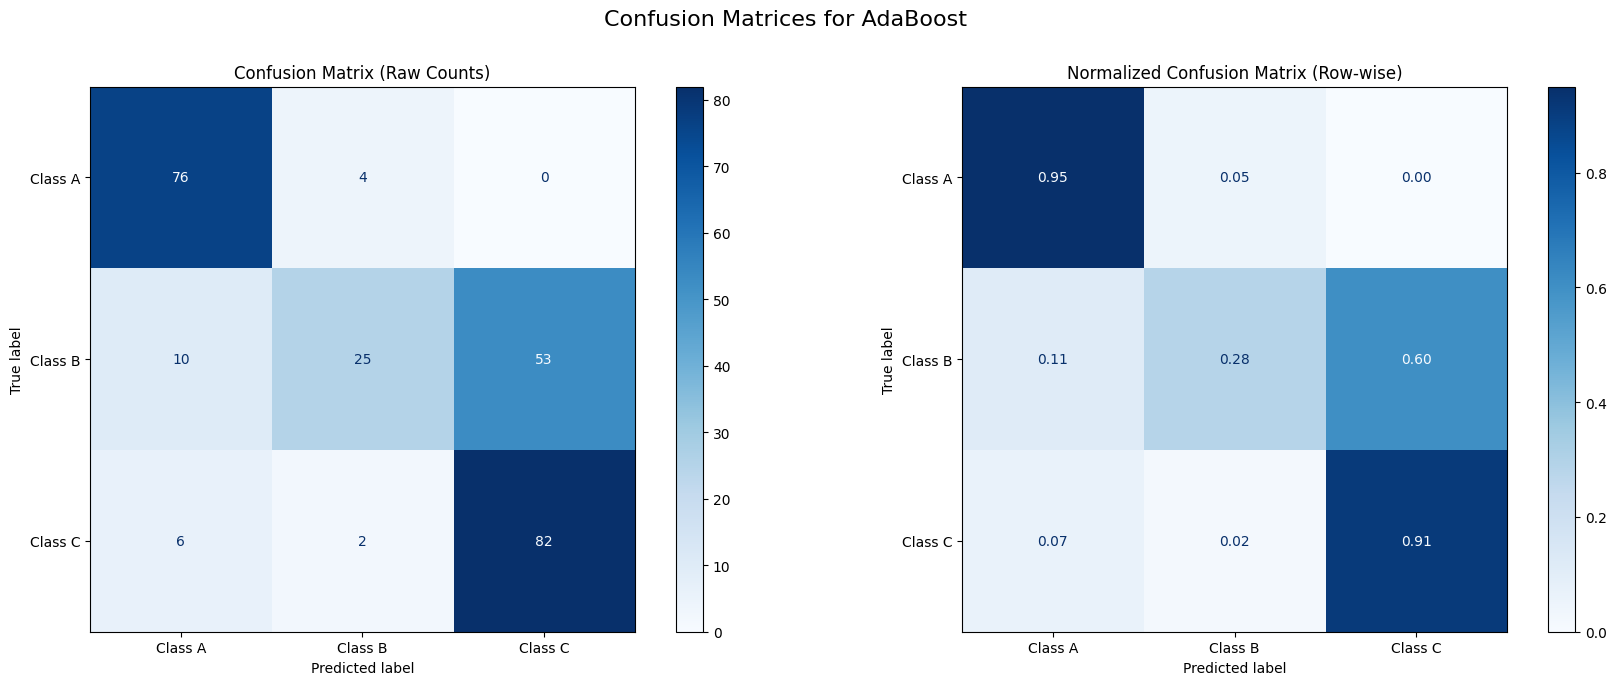

In [17]:
best_ab = AdaBoostClassifier(**ab_study.best_params)
best_ab.fit(X_resampled, y_resampled)  # Fit on the final full (resampled) train set

# Evaluate
predictions = evaluate_optuna_model("AdaBoost", best_ab, X_test, y_test)
plot_confusion_matrix_sklearn(y_test, predictions, class_names=['Class A', 'Class B', 'Class C'], model_name="AdaBoost", figsize=(18, 7), cmap=plt.cm.Blues) # type: ignore

# Create Model

In [18]:
def predict_fertility(model, features, show_proba=True):
    import numpy as np
    import pandas as pd

    label_map = {0: "Less Fertile", 1: "Fertile", 2: "Highly Fertile"}

    # Convert list to DataFrame if needed
    if isinstance(features, list) or isinstance(features, np.ndarray):
        columns = ["N", "P", "K", "ph", "ec", "oc", "S", "zn", "fe", "cu", "Mn", "B"]
        features = pd.DataFrame([features], columns=columns)

    # Predict class
    prediction = model.predict(features)[0]
    result = label_map[int(prediction)]

    if show_proba and hasattr(model, "predict_proba"):
        probs = model.predict_proba(features)[0]
        print("🌾 Class Probabilities:")
        for i, p in enumerate(probs):
            print(f"  {label_map[i]}: {p:.4f}")

    print(f"\n Predicted Fertility Class: {result}")
    return result


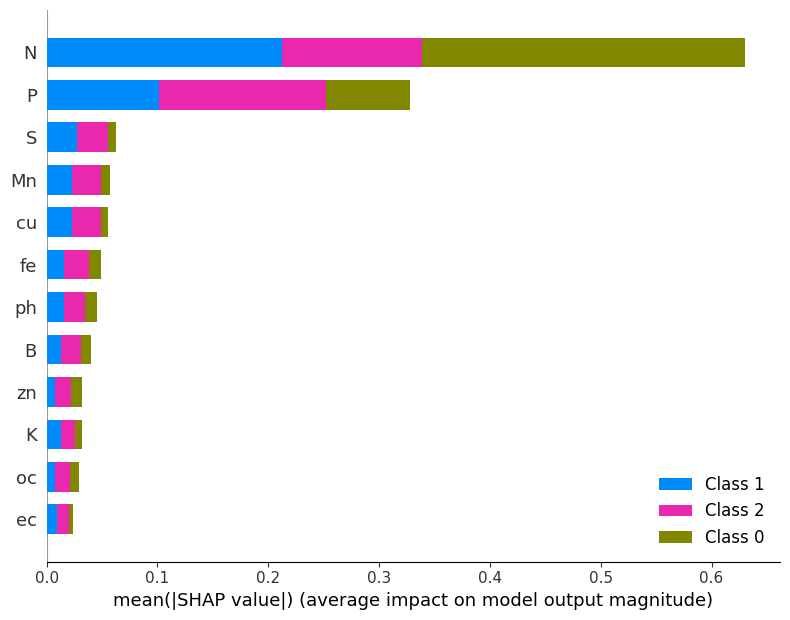

In [22]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(best_rf, X_train)

# Compute SHAP values for test data (disable additivity check)
shap_values_test = explainer(X_test, check_additivity=False)

# Visualize SHAP values
shap.summary_plot(shap_values_test, X_test)


In [19]:
import pandas as pd

# Sample input data
sample = [138, 8.6, 560, 7.46, 0.62, 0.7, 5.9, 0.24, 0.31, 0.77, 8.71, 0.11]
#sample = [270, 7, 391, 7.4, 0.61, 0.67, 27.1, 0.42, 1.18, 1.04, 2.76, 1.62]


# Feature names in order used during training
columns = ["N", "P", "K", "ph", "ec", "oc", "S", "zn", "fe", "cu", "Mn", "B"]

# Create single-row DataFrame
sample = pd.DataFrame([sample], columns=columns)

predict_fertility(best_rf, sample)


🌾 Class Probabilities:
  Less Fertile: 0.9090
  Fertile: 0.0760
  Highly Fertile: 0.0150

 Predicted Fertility Class: Less Fertile


'Less Fertile'